In [18]:
from smartem.segmentation import segmenter, utils
from skimage import measure, segmentation
from smartem.offline.train_mb_error_detector.NNtools import UNet

import h5py
import matplotlib.pyplot as plt
import torch
import numpy as np
import pyvoi
import pandas as pd
import seaborn as sns
import segmentation_models_pytorch as smp
from skimage import io
from tqdm import tqdm
import os

import importlib
importlib.reload(segmenter)

<module 'smartem.segmentation.segmenter' from '/home/ssawmya-local/FM_work/SmartEM/smartem/segmentation/segmenter.py'>

## Set variables

In [19]:
data_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"
device = torch.device("cuda:2")

In [20]:
models_path = "/storage2/projects/smartEM/EM2MB_networks"

models = ['mit_b0', 'mit_b1', 'mit_b2', 'mit_b3', 'mit_b4', 'mit_b5', 'resnet18', 'resnet101', 'resnet50', 'resnet101', 'resnext101_32x8d', 'resnext101_32x16d']

In [21]:
collector_dwts = {}
collector_hdt_vois = {}
for model_name in models:
    model_path = os.path.join(models_path, f"best_model_{model_name}.pth")
    Iseg = segmenter.Segmenter(model_path, segmenter_function = measure.label, device=device)
    Iseg.set_model_directly()

    data_dwts = []
    data_hdt_vois = []


    with h5py.File(data_path, "r") as f:
        for reg in tqdm(f.keys(), desc="segmenting regions..."):
            group = f[reg]

            dwts = [int(dwt) for dwt in list(group.keys())]
            
            dwts.sort()
            # print(dwts)
            # break
            slowest_dwt = dwts[-1]

            mask = group[f"{slowest_dwt}/mask"][()]
            # gt_labels = measure.label(255 - mask)

            # if gt_labels.shape[0] % 32 != 0:
            #     gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

            # 1200ns
            im = group[f"{slowest_dwt}/im"][()]
            hdt_labels = Iseg.get_labels(im)


            # all dwts
            for dwt in tqdm(group.keys(), desc="segmenting dwell times...", leave=False):
                im = group[f"{dwt}/im"][()]

                labels = Iseg.get_labels(im)

                # voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
                voi_hdt,_,_ = pyvoi.VI(hdt_labels.flatten(), labels.flatten())
                # data_gt_vois.append(voi_gt.item())
                data_hdt_vois.append(voi_hdt.item())

                data_dwts.append(int(dwt))

    collector_dwts[model_name] = data_dwts
    collector_hdt_vois[model_name] = data_hdt_vois

    print(model_name, np.mean(data_hdt_vois))
    # break

# data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois}
# df = pd.DataFrame(data=data)

Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [01:54<00:00,  6.35s/it]


mit_b0 0.2645166093811101
Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [02:09<00:00,  7.22s/it]


mit_b1 0.3089679386392827
Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [03:05<00:00, 10.32s/it]


mit_b2 0.05456977593706734
Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [04:11<00:00, 13.95s/it]


mit_b3 0.3266387749851371
Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [05:24<00:00, 18.04s/it]


mit_b4 0.3304614570317051
Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [06:04<00:00, 20.25s/it]


mit_b5 0.4027009117934439
Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [01:22<00:00,  4.57s/it]


resnet18 5.062916432233044e-05
Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [01:47<00:00,  5.97s/it]


resnet101 0.0005739461023098095
Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [01:35<00:00,  5.33s/it]


resnet50 0.0007445051789747797
Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [01:46<00:00,  5.93s/it]


resnet101 0.0005739461023098095
Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [02:25<00:00,  8.09s/it]


resnext101_32x8d 0.00023764420285217404
Not using custom watershed function - will invert images before segmenting...


segmenting regions...: 100%|██████████| 18/18 [03:23<00:00, 11.31s/it]

resnext101_32x16d 0.0007216013391082506


In [30]:
data = {"Dwell Time (ns)": collector_dwts['mit_b2'], "Variation of Information from 1200ns (nats)": collector_hdt_vois['mit_b2']}
df = pd.DataFrame(data=data)

<Axes: xlabel='Dwell Time (ns)', ylabel='Variation of Information from 1200ns (nats)'>

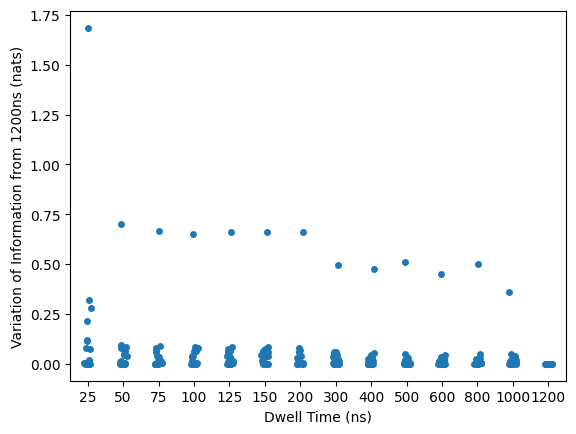

In [31]:
sns.stripplot(data=df, y="Variation of Information from 1200ns (nats)", x="Dwell Time (ns)")

In [ ]:
collector_hdt_vois['mit_b5']

In [4]:
model = smp.Unet(
    encoder_name='resnet50', 
    encoder_weights='imagenet', 
    classes=2, 
    activation='sigmoid',
)

model_path = '/home/tommy-local/projects/smartem/smartem_support/fusedem2mb/best_model_EM2MB_noslow_state.pth'

## Make Segmenter object

In [9]:
Iseg = segmenter.Segmenter(model_path, segmenter_function = segmentation.watershed, device=device)
Iseg.set_model(model_class=model)


Using watershed function...


## Compute VI vs. Dwell Time

In [12]:
data_dwts = []
data_hdt_vois = []
data_gt_vois = []

with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), desc="segmenting regions..."):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # 1200ns
        im = group[f"{slowest_dwt}/im"][()]
        hdt_labels = Iseg.get_labels(im)


        # all dwts
        for dwt in tqdm(group.keys(), desc="segmenting dwell times...", leave=False):
            im = group[f"{dwt}/im"][()]

            labels = Iseg.get_labels(im)

            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels.flatten(), labels.flatten())
            data_gt_vois.append(voi_gt.item())
            data_hdt_vois.append(voi_hdt.item())
            data_dwts.append(int(dwt))



data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois}
df = pd.DataFrame(data=data)

segmenting regions...:   0%|          | 0/18 [00:00<?, ?it/s]

segmenting regions...: 100%|██████████| 18/18 [05:22<00:00, 17.89s/it]


<Axes: xlabel='Dwell Time (ns)', ylabel='Variation of Information from 1200ns (nats)'>

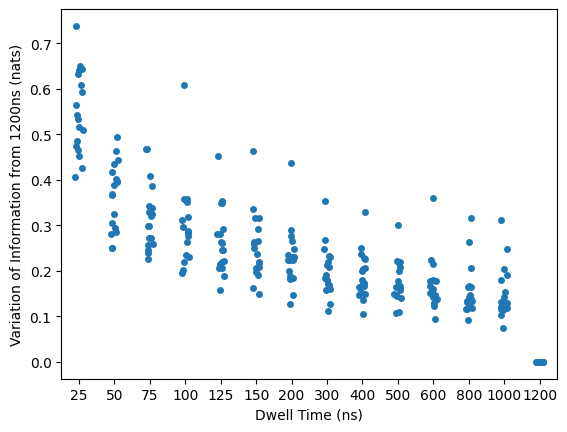

In [13]:
sns.stripplot(data=df, y="Variation of Information from 1200ns (nats)", x="Dwell Time (ns)")

## Visualize result

In [32]:
images = {}

desired_dwts = [25, 50, 100, 400, 800, 1200]

model_name = "mit_b2"
model_path = os.path.join(models_path, f"best_model_{model_name}.pth")
Iseg = segmenter.Segmenter(model_path, segmenter_function = measure.label, device=device)
Iseg.set_model_directly()

with h5py.File(data_path, "r") as f:
    reg = list(f.keys())[0]
    group = f[reg]

    dwts = [int(dwt) for dwt in list(group.keys())]
    dwts.sort()
    slowest_dwt = dwts[-1]
    
    mask = group[f"{slowest_dwt}/mask"][()]

    gt_labels = measure.label(255 - mask)
    if gt_labels.shape[0] % 32 != 0:
        gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
    gt_labels_shuffled = utils.shuffle_labels(gt_labels)
    gt_labels_masked = np.ma.masked_where(gt_labels_shuffled == 0, gt_labels_shuffled)

    for dwt in desired_dwts:
        im = group[f"{dwt}/im"][()]

        _, mb_probs = Iseg.get_membranes(im, get_probs=True)
        labels = Iseg.get_labels(im)

        labels_shuffled = utils.shuffle_labels(labels)
        labels_masked = np.ma.masked_where(labels_shuffled == 0, labels_shuffled)

        voi,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
        title_stem = f"{dwt}ns_VOI_{voi.item():.2f}"

        images[title_stem + "_image"] = im
        images[title_stem + "_label"] = labels_masked
        images[title_stem + "_pred"] = mb_probs


images["ground_truth_image"] = im
images["ground_truth_label"] = gt_labels_masked
images["ground_truth_pred"] = mask
images["high_dwell_time_image"] = im


Not using custom watershed function - will invert images before segmenting...


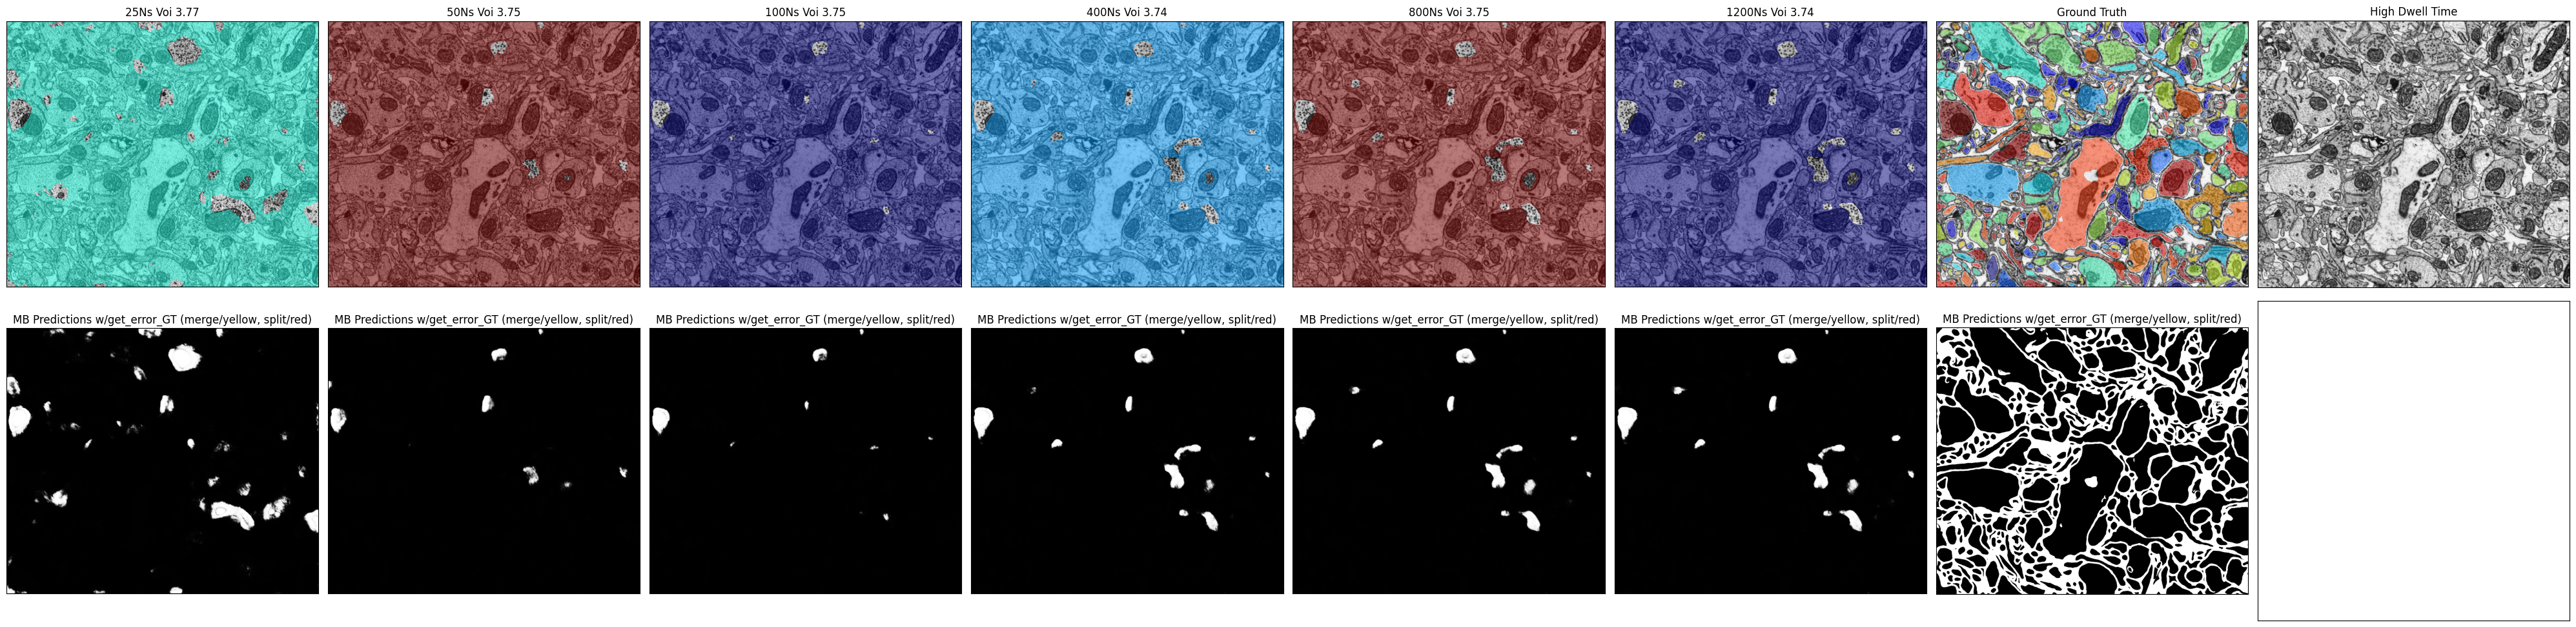

In [33]:
utils.visualize(**images)

## Save MB probs

In [37]:
out_path = "/storage2/projects/smartEM/em-vis/em2mb_preds/"
desired_dwts = [50, 1200]

with h5py.File(data_path, "r") as f:
    for reg in tqdm(list(f.keys()), desc="predicting images..."):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        # all dwts
        for dwt in desired_dwts:

            im = group[f"{dwt}/im"][()]
            mask = group[f"{dwt}/mask"][()]

            im = np.pad(im, ((12,12), (0,0)))
            #print(f"{mask.shape}, {mask.dtype}, {np.amin(mask)}-{np.median(mask)}-{np.amax(mask)}")
            #print(f"{im.shape}, {im.dtype}, {np.amin(im)}-{np.median(im)}-{np.amax(im)}")

            _, mb_probs = Iseg.get_membranes(im, get_probs=True)

            mb_probs = mb_probs[12:-12,:]
            mb_probs = (mb_probs * 255).astype(np.uint8)
            #print(f"{mb_probs.shape}, {mb_probs.dtype}, {np.amin(mb_probs)}-{np.median(mb_probs)}-{np.amax(mb_probs)}")

            f_path = out_path + f"reg_{reg}_dwt_{dwt}_em2mb_pred.png"
            io.imsave(f_path, mb_probs)
            f_path_mask = out_path + f"reg_{reg}_dwt_{dwt}_gt.png"
            io.imsave(f_path_mask, mask)

            # plt.imshow(mb_probs, cmap='gray')
            # plt.show()
            # plt.imshow(mask, cmap='gray')
            # plt.show()
            
            #raise ValueError()




predicting images...: 100%|██████████| 8/8 [00:12<00:00,  1.50s/it]


## Compute VI vs. Step Size

In [7]:
data_av_hdt_vois = []
data_step_size = []

dwt = 50
step_sizes = [128, 256, 512, 1024]

with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), desc="segmenting regions..."):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # 1200ns
        im = group[f"{slowest_dwt}/im"][()]
        hdt_labels = Iseg.get_labels(im)


        im = group[f"{dwt}/im"][()]
        im = im[:1024, :]
        for step_size in tqdm(step_sizes, desc="Changing step size...", leave=False):
            vois = []
            for step in range(0, im.shape[0], step_size):
                im_step = im[step:step+step_size]
                hdt_labels_step = hdt_labels[step:step+step_size]
                labels_step = Iseg.get_labels(im_step)
                voi_hdt,_,_ = pyvoi.VI(hdt_labels_step.flatten(), labels_step.flatten())
                voi_hdt = voi_hdt.item()
                vois.append(voi_hdt)

            data_step_size.append(step_size)
            data_av_hdt_vois.append(np.mean(vois))



data = {"Step Size (pixels)": data_step_size, "Av. Variation of Information from Slow Dwell Time Segmentation": data_av_hdt_vois}
df = pd.DataFrame(data=data)

segmenting regions...: 100%|██████████| 18/18 [01:16<00:00,  4.27s/it]


In [10]:
data = {"Step Size (pixels)": data_step_size, "Av. VoI from Slow Dwell Time Segmentation": data_av_hdt_vois}
df = pd.DataFrame(data=data)

Text(0.5, 1.0, 'Effect of Image Stepping on EM2MB Segmentation')

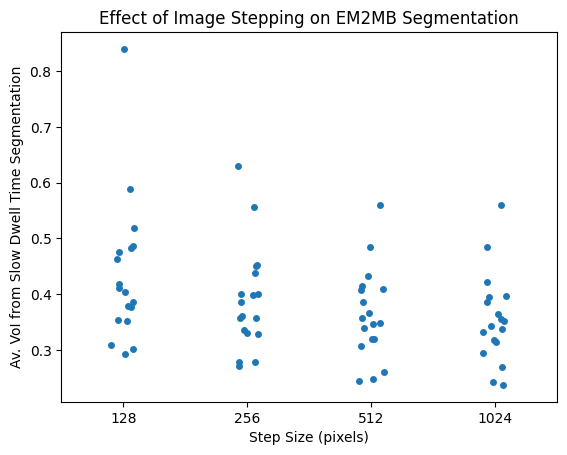

In [12]:
sns.stripplot(data=df, y="Av. VoI from Slow Dwell Time Segmentation", x="Step Size (pixels)")
plt.title("Effect of Image Stepping on EM2MB Segmentation")

In [16]:
def get_IoU(gt, pred):
    intersection = np.logical_and(gt, pred)
    union = np.logical_or(gt, pred)
    return np.sum(intersection) / np.sum(union)

In [20]:
data_hdt_vois = []
data_step_size = []
data_av_hdt_ious = []

dwt = 50
step_sizes = [128, 256, 512, 1024]

with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), desc="segmenting regions..."):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # 1200ns
        im = group[f"{slowest_dwt}/im"][()]
        
        hdt_labels = Iseg.get_labels(im)
        hdt_membranes = Iseg.get_membranes(im)

        im = group[f"{dwt}/im"][()]
        im = im[:1024, :]
        for step_size in tqdm(step_sizes, desc="Changing step size...", leave=False):
            vois = []
            ious = []
            membranes = np.zeros_like(im)
            for step in range(0, im.shape[0], step_size):
                im_step = im[step:step+step_size]
                membranes_step = Iseg.get_membranes(im_step)
                membranes[step:step+step_size] = membranes_step

                iou_step = get_IoU(membranes_step, hdt_membranes[step:step+step_size])
                ious.append(iou_step)
            
            labels = Iseg.get_labels_from_membrane(membranes)
            
            # print(labels.shape, hdt_labels.shape)
            voi_hdt,_,_ = pyvoi.VI(hdt_labels[:1024,:].flatten(), labels.flatten())
            voi_hdt = voi_hdt.item()
            data_step_size.append(step_size)
            data_av_hdt_ious.append(np.mean(ious))
            # data_av_hdt_vois.append(np.mean(vois))
            data_hdt_vois.append(voi_hdt)



segmenting regions...: 100%|██████████| 18/18 [01:27<00:00,  4.85s/it]


In [24]:
# data = {"Step Size (pixels)": data_step_size, "Variation of Information from Slow Dwell Time Segmentation": data_hdt_vois}
data = {"Step Size (pixels)": data_step_size, "Av. IoU from Slow Dwell Time MB": data_av_hdt_ious, "Variation of Information from Slow Dwell Time Segmentation": data_hdt_vois}
df = pd.DataFrame(data=data)

Text(0.5, 1.0, 'Effect of Image Stepping on EM2MB Segmentation')

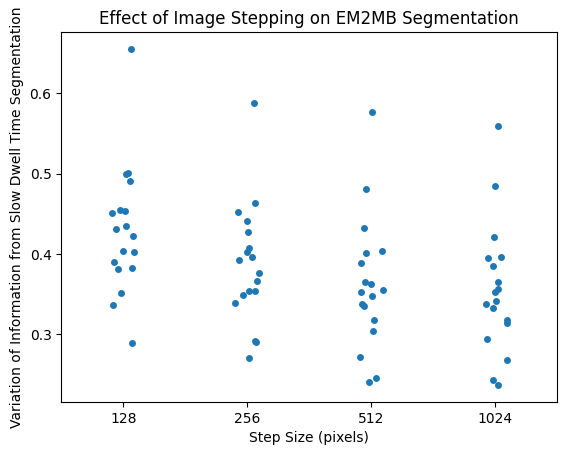

In [15]:
sns.stripplot(data=df, y="Variation of Information from Slow Dwell Time Segmentation", x="Step Size (pixels)")
plt.title("Effect of Image Stepping on EM2MB Segmentation")

Text(0.5, 1.0, 'Effect of Image Stepping on EM2MB Segmentation')

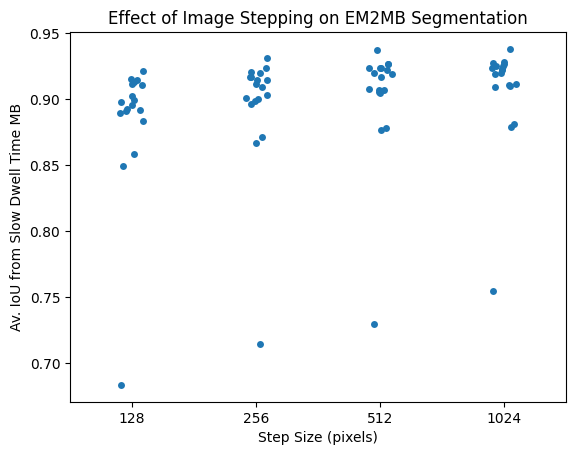

In [25]:
sns.stripplot(data=df, y="Av. IoU from Slow Dwell Time MB", x="Step Size (pixels)")
plt.title("Effect of Image Stepping on EM2MB Segmentation")

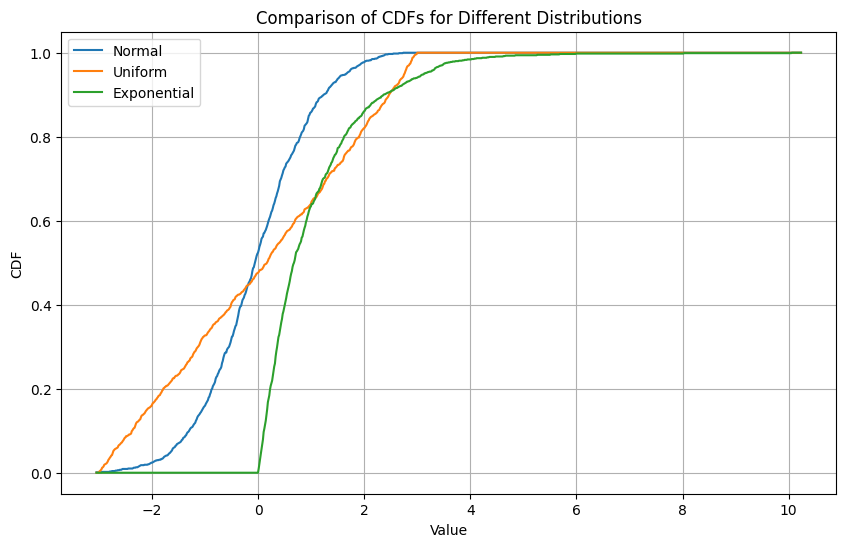

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Generate sample data
np.random.seed(0)
data_normal = np.random.normal(loc=0, scale=1, size=1000)
data_uniform = np.random.uniform(low=-3, high=3, size=1000)
data_exponential = np.random.exponential(scale=1, size=1000)

# Function to calculate CDF
def compute_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    return sorted_data, cdf

# Compute CDFs
x_normal, y_normal = compute_cdf(data_normal)
x_uniform, y_uniform = compute_cdf(data_uniform)
x_exponential, y_exponential = compute_cdf(data_exponential)

# Interpolate CDFs over a common x-range
x_common = np.linspace(min(min(x_normal), min(x_uniform), min(x_exponential)), 
                       max(max(x_normal), max(x_uniform), max(x_exponential)), 1000)

f_normal = interp1d(x_normal, y_normal, kind='nearest', bounds_error=False, fill_value=(0,1))
f_uniform = interp1d(x_uniform, y_uniform, kind='nearest', bounds_error=False, fill_value=(0,1))
f_exponential = interp1d(x_exponential, y_exponential, kind='nearest', bounds_error=False, fill_value=(0,1))

y_normal_interp = f_normal(x_common)
y_uniform_interp = f_uniform(x_common)
y_exponential_interp = f_exponential(x_common)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_common, y_normal_interp, label='Normal')
plt.plot(x_common, y_uniform_interp, label='Uniform')
plt.plot(x_common, y_exponential_interp, label='Exponential')
plt.title('Comparison of CDFs for Different Distributions')
plt.xlabel('Value')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()


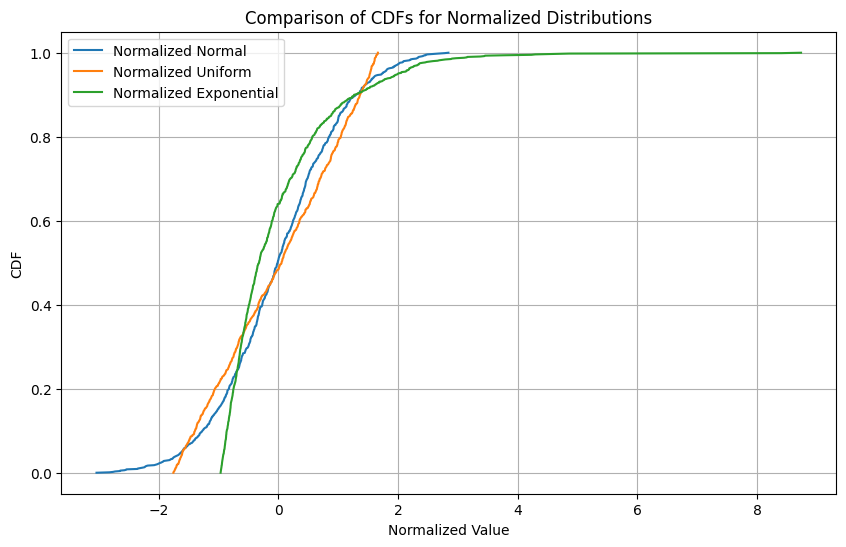

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(0)
data_normal = np.random.normal(loc=0, scale=1, size=1000)
data_uniform = np.random.uniform(low=-3, high=3, size=1000)
data_exponential = np.random.exponential(scale=1, size=1000)

# Normalize data to zero mean and unit variance
normalize = lambda data: (data - np.mean(data)) / np.std(data)
data_normal_normalized = normalize(data_normal)
data_uniform_normalized = normalize(data_uniform)
data_exponential_normalized = normalize(data_exponential)

# Function to calculate CDF
def compute_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    return sorted_data, cdf

# Compute CDFs
x_normal, y_normal = compute_cdf(data_normal_normalized)
x_uniform, y_uniform = compute_cdf(data_uniform_normalized)
x_exponential, y_exponential = compute_cdf(data_exponential_normalized)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_normal, y_normal, label='Normalized Normal')
plt.plot(x_uniform, y_uniform, label='Normalized Uniform')
plt.plot(x_exponential, y_exponential, label='Normalized Exponential')
plt.title('Comparison of CDFs for Normalized Distributions')
plt.xlabel('Normalized Value')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()

